In [1]:
import os
import glob
from io import open

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,'"
n_letters = len(all_letters)

# Turn a unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a listt of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
# Turning names into Tensors
# To represent a single letter, we use a "one-hot vector" of size <1 x n_letters>. 
# T0 ake a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>

import torch

# Find the letter index from all_letters eg "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a letter into a <1 x n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
torch.Size([5, 1, 55])


In [7]:
# Creating the network
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8726, -3.0139, -2.8271, -2.8277, -2.8319, -2.9111, -2.8910, -2.9992,
         -2.8423, -2.9878, -2.8343, -2.9200, -2.7299, -2.8752, -2.9373, -3.0843,
         -2.8519, -2.8502]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
# Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 12)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Seif
category = Polish / line = Zdunowski
category = Dutch / line = Sneijder
category = Spanish / line = Grec
category = Polish / line = Wyrick
category = Irish / line = O'Halloran
category = Greek / line = Matsoukis
category = Scottish / line = Jones
category = Russian / line = Zelensky
category = Russian / line = Agudov


In [12]:
# Training the network
criterion = nn.NLLLoss()

In [18]:
# Training Loop
learning_rate = 0.005


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [21]:
import math
import time

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)

    current_loss += loss

    # Print ''iter'' number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.0943 Durante / Italian ✓
10000 10% (0m 18s) 0.9879 Delacruz / Spanish ✓
15000 15% (0m 27s) 1.3342 Santos / Greek ✗ (Portuguese)
20000 20% (0m 35s) 2.4801 Magalhaes / French ✗ (Portuguese)
25000 25% (0m 44s) 2.6441 Oesterreicher / German ✗ (Czech)
30000 30% (0m 53s) 1.0919 Lim / Chinese ✗ (Korean)
35000 35% (1m 2s) 0.5661 Echeverria / Spanish ✓
40000 40% (1m 11s) 2.5915 Muirchertach / German ✗ (Irish)
45000 45% (1m 21s) 0.1342 Vuong / Vietnamese ✓
50000 50% (1m 30s) 0.7666 Armbruster / German ✓
55000 55% (1m 39s) 1.2472 Tomanek / Russian ✗ (Czech)
60000 60% (1m 49s) 0.4907 Anderson / Scottish ✓
65000 65% (1m 58s) 0.4985 Antoun / Arabic ✓
70000 70% (2m 8s) 0.2662 Delgado / Portuguese ✓
75000 75% (2m 17s) 1.0020 Broomfield / English ✓
80000 80% (2m 27s) 0.4206 Kanada / Japanese ✓
85000 85% (2m 37s) 0.5037 Bonnet / French ✓
90000 90% (2m 46s) 0.0057 Sakelaris / Greek ✓
95000 95% (2m 56s) 5.1223 Michel / Polish ✗ (French)
100000 100% (3m 6s) 0.0103 Youj / Korean ✓


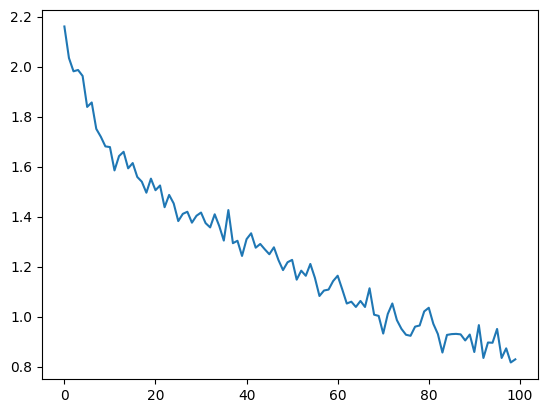

In [22]:
# plotting the results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\Vishal\AppData\Local\Temp\ipykernel_16640\2481212727.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Vishal\AppData\Local\Temp\ipykernel_16640\2481212727.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


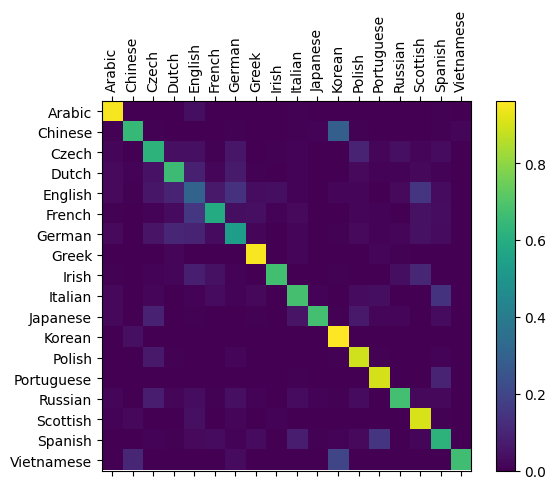

In [24]:
# Evaluating the results
# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by it's sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# setup axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [25]:
# Running on user input
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.75) Russian
(-1.11) Czech
(-2.80) Irish

> Jackson
(-0.81) Scottish
(-0.84) English
(-2.83) Czech

> Satoshi
(-0.53) Japanese
(-1.44) Arabic
(-2.55) Greek
